# Estudio de resultados

En este notebook, se muestran las métricas obtenidas para los diferentes modelos evaluados mediante el dataset Household Power Consumption del portal UCI (https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption). El objetivo es estudiar el impacto de diferentes estrategias de encoding para ver cuál nos permite obtener mejores resultados en secuencias de larga extensión.

Examinaremos las siguientes alternativas:
- Uso de estadísticos básicos: media, std, min y max.
- Uso de estadísticos + lags anteriores mediante ventana.
- Uso de SPE
- Uso de SPE + otros encodings absolutos
- Estudio ponderado de PE varios
- Estudio ponderado sin normalizar
- Informer Original
- Uso de TPE

Tras dichas pruebas, examinaremos la mejor alternativa en base a las métricas y el costo computacional, y probaremos a experimentar si realmente la información añadida tiene impacto en la calidad de los resultados realizando Shuffle del contexto de entrada del encoder en test.

## Evaluación de los 8 modelos de PE

Comenzaremos experimentando primero cuál de las 8 alternativas propuestas permite obtener un mejor resultados. En muchas de ellas, como ya se comentaba, se utilizan diversas estrategias de encoding ponderadas, ya que así el modelo puede decidir cuál de ellas es la que mejor se adapta al problema. Esto se debe a que, en ocasiones, la coexistencia de varios métodos no tiene por qué empeorar el resultado, ya que cada problema requiere unas necesidades específicas, en función de la correlación de los datos, y no existe una codificación de PE absoluta mejor en todos los casos.

A continuación, procederemos a la lectura de los ficheros csv que contienen los resultados, y compararemos tanto en tabla como gráficamente sus resultados. Nos fijaremos especialmente en MAE Y MSE, recurriendo al resto de métricas cuando no exista una diferencia clara.

In [1]:
import pandas as pd

# Ficheros con sus nombres de modelo
model_files = {
    "HPC_ALL_PE": "../ResultadosNGPU/HPC_ALL_PE_v2.csv",
    "HPC_ALL_PE_NoNorm": "../ResultadosNGPU/HPC_ALL_PE_v2_NoNorm.csv",
    "HPC_Informer_Original": "../ResultadosNGPU/HPC_Orig.csv",
    "HPC_SPE": "../ResultadosNGPU/HPC_SPE.csv",
    "HPC_SPE_ALL": "../ResultadosNGPU/HPC_SPE_ALL.csv",
    "HPC_Ventana_Stats": "../ResultadosNGPU/HPC_Stats_Only.csv",
    "HPC_TPE": "../ResultadosNGPU/HPC_TPE.csv",
    "HPC_Ventana_Stats_Lags": "../ResultadosNGPU/HPC_Ventana_Lags.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo
    
    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')
    
    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]
    
    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)
    
    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostrar
display(final_df)


../ResultadosNGPU/HPC_ALL_PE_v2.csv
../ResultadosNGPU/HPC_ALL_PE_v2_NoNorm.csv
../ResultadosNGPU/HPC_Orig.csv
../ResultadosNGPU/HPC_SPE.csv
../ResultadosNGPU/HPC_SPE_ALL.csv
../ResultadosNGPU/HPC_Stats_Only.csv
../ResultadosNGPU/HPC_TPE.csv
../ResultadosNGPU/HPC_Ventana_Lags.csv


,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,HPC_ALL_PE,0.373488,2.251120,0.461892,986.080587,0.679617,350.836037,18652.724426,0.006858,0.091233,0.004841,128.446180,0.003558,5.567514,128.342962
6,HPC_TPE,0.374392,2.252478,0.463651,954.171082,0.680918,296.252991,18913.633506,0.004132,0.001750,0.001917,38.396774,0.001408,1.955109,28.792701
1,HPC_ALL_PE_NoNorm,0.393849,2.240669,0.473760,954.817383,0.688295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,HPC_Ventana_Stats_Lags,0.398612,2.312104,0.491026,1012.281759,0.700723,229.312370,13071.568639,0.005025,0.086223,0.004988,108.017980,0.003566,3.086725,1403.397188
5,HPC_Ventana_Stats,0.394002,2.487715,0.502033,1196.131307,0.708535,253.980487,17697.790107,0.002849,0.090071,0.004632,105.107660,0.003274,3.765932,3174.414850
2,HPC_Informer_Original,0.402445,2.602580,0.525711,1374.003215,0.725016,113.442166,8618.726252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HPC_SPE,0.417545,2.518025,0.553648,1348.892415,0.743617,1461.875124,111056.220972,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HPC_SPE_ALL,0.441418,2.558296,0.582600,1388.203491,0.762703,1730.330627,131450.338871,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Podemos apreciar que el modelo con mejor rendimiento es el basado en varios encodings posicionales los cuales han sido normalizados y ponderados con pesos entre 0 y 1 mediante SoftMax. Son los que mejores resultados ofrecen en MSE, pero también está dentro del top cuando observamos MAE o RMSE, pero ahí si existen leves mejoras en otros modelos. Sin embargo, dado a la cercanía de estas otras alternativas, y a su mayor coste computacional, podríamos considerar que el modelo propuesto en la primera fila es aquel que debemos comparar y verificar con respecto al modelo original.

Para ver los resultados de forma gráfica, podemos representar los valores de MSE y MAE en un gráfico de barras.

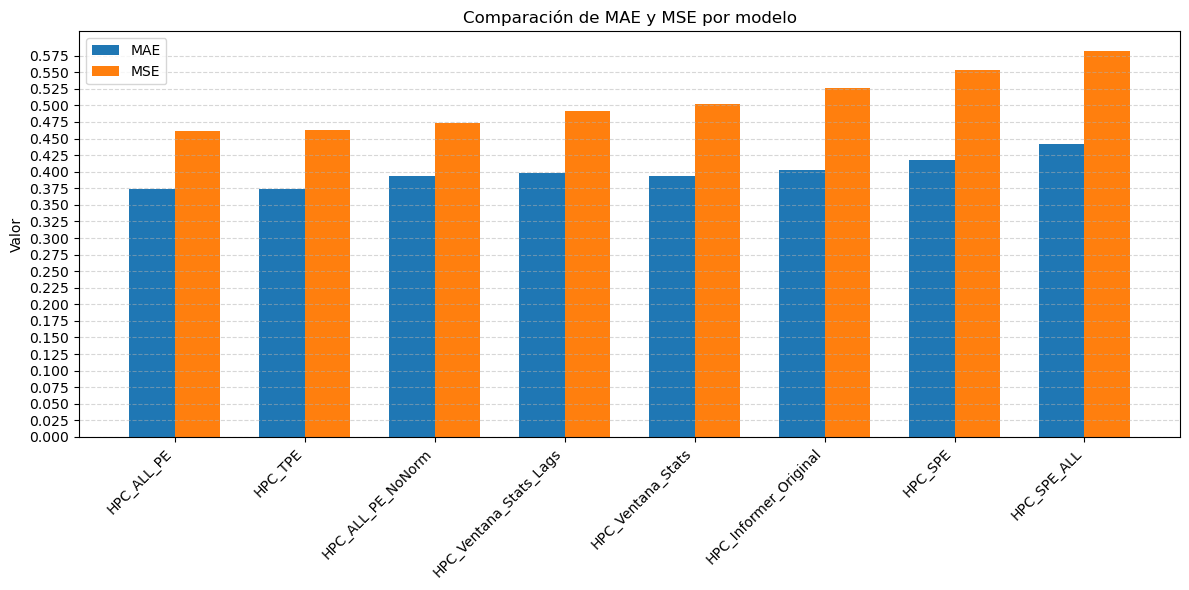

In [2]:
import matplotlib.pyplot as plt
import numpy as np

metricas = ['MAE_Mean', 'MSE_Mean']
df_plot = final_df[['Modelo'] + metricas]

# Configurar el gráfico
x = df_plot['Modelo']
x_pos = range(len(x))
width = 0.35  # ancho de las barras

# Crear las barras
fig, ax = plt.subplots(figsize=(12, 6))

# Barras para MAE
ax.bar([p - width / 2 for p in x_pos], df_plot['MAE_Mean'], width=width, label='MAE')

# Barras para MSE
ax.bar([p + width / 2 for p in x_pos], df_plot['MSE_Mean'], width=width, label='MSE')

# Etiquetas y leyenda
ax.set_xticks(x_pos)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.set_yticks(np.arange(0, .6, 0.025))
ax.set_ylabel('Valor')
ax.set_title('Comparación de MAE y MSE por modelo')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Comparativa del mejor modelo con Informer original

Una vez seleccionado el modelo que queremos comprobar, podemos pasar a ejecutar un experimento: comprobar si el positional encoding está realmente ayudando a aportar valor al modelo. Para ello, podemos realizar un pequeño experimento en el cual, mezclar los valores de entrada de referencia para el decoder, y ver si así se obtienen resultados similares a introducirlos originales.

Lo que buscamos es ver si la información añadida por el PE realmente ayuda al modelo a aprender información local, o si por consiguiente, se está desaprovechando cómputo a cambio leves mejoras o incluso empeoramiento.

Al igual que en el apartado anterior, procederemos a la lectura de resultados de 4 modelos:
- Estadísticos + lags original
- Estadísticos + lags desordenado
- Informer original
- Informer desordenado


In [3]:
# Ficheros con sus nombres de modelo
model_files = {
    "HPC_ALL_PE": "../ResultadosNGPU/HPC_ALL_PE_v2.csv",
    "HPC_ALL_PE_Shuffled": "../ResultadosNGPU/HPC_ALL_PE_v2_Shuffled.csv",
    "HPC_InformerOriginal": "../ResultadosNGPU/HPC_Orig.csv",
    "HPC_InformerOriginal_Shuffled": "../ResultadosNGPU/HPC_Orig_Shuffled.csv",
    "HPC_No_PE.csv": "../ResultadosNGPU/HPC_No_PE.csv",
    "HPC_TPE": "../ResultadosNGPU/HPC_TPE.csv",
    "HPC_TPE_Shuffled": "../ResultadosNGPU/HPC_TPE_Shuffled.csv"

}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo
    
    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')
    
    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]
    
    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)
    
    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostrar
display(final_df)

../ResultadosNGPU/HPC_ALL_PE_v2.csv
../ResultadosNGPU/HPC_ALL_PE_v2_Shuffled.csv
../ResultadosNGPU/HPC_Orig.csv
../ResultadosNGPU/HPC_Orig_Shuffled.csv
../ResultadosNGPU/HPC_No_PE.csv
../ResultadosNGPU/HPC_TPE.csv
../ResultadosNGPU/HPC_TPE_Shuffled.csv


,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,HPC_ALL_PE,0.373488,2.251120,0.461892,986.080587,0.679617,350.836037,18652.724426,0.006858,0.091233,0.004841,128.446180,0.003558,5.567514,128.342962
5,HPC_TPE,0.374392,2.252478,0.463651,954.171082,0.680918,296.252991,18913.633506,0.004132,0.001750,0.001917,38.396774,0.001408,1.955109,28.792701
2,HPC_InformerOriginal,0.402445,2.602580,0.525711,1374.003215,0.725016,113.442166,8618.726252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HPC_InformerOriginal_Shuffled,0.420219,2.699172,0.543977,1392.800456,0.737512,114.538184,8616.702174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HPC_ALL_PE_Shuffled,0.581124,2.427627,0.782092,716.527344,0.884222,330.988508,20842.951120,0.021991,0.106249,0.027368,69.707450,0.015572,6.040981,1877.777867
6,HPC_TPE_Shuffled,0.581001,2.740639,0.851115,1022.612895,0.922467,295.005139,20580.513685,0.046717,0.080763,0.024083,95.225204,0.013023,1.204927,2278.562719
4,HPC_No_PE.csv,0.746981,12.890603,0.957441,48193.601562,0.977416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


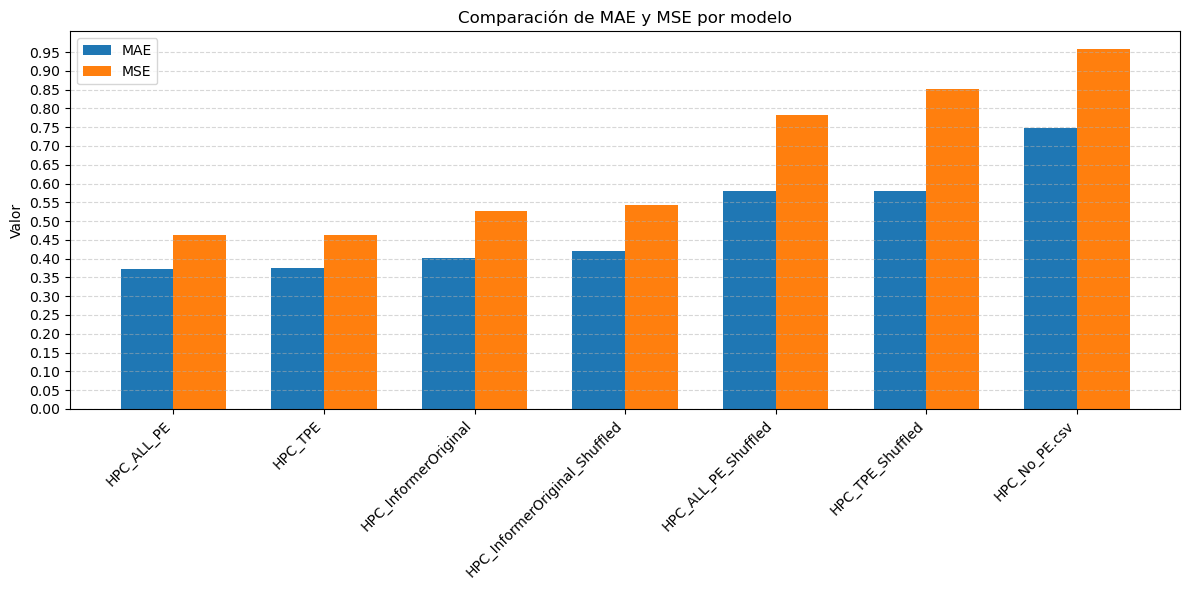

In [4]:
import matplotlib.pyplot as plt
import numpy as np

metricas = ['MAE_Mean', 'MSE_Mean']
df_plot = final_df[['Modelo'] + metricas]

# Configurar el gráfico
x = df_plot['Modelo']
x_pos = range(len(x))
width = 0.35  # ancho de las barras

# Crear las barras
fig, ax = plt.subplots(figsize=(12, 6))

# Barras para MAE
ax.bar([p - width / 2 for p in x_pos], df_plot['MAE_Mean'], width=width, label='MAE')

# Barras para MSE
ax.bar([p + width / 2 for p in x_pos], df_plot['MSE_Mean'], width=width, label='MSE')

# Etiquetas y leyenda
ax.set_xticks(x_pos)
ax.set_xticklabels(x, rotation=45, ha='right')
ax.set_yticks(np.arange(0, 1, 0.05))
ax.set_ylabel('Valor')
ax.set_title('Comparación de MAE y MSE por modelo')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Podemos apreciar, claramente, que el impacto de mezclar la información de referencia en el encoder afecta de manera considerable a la alternativa que usa ventana de estadísticos, ya que se está rompiendo considerablemente la estructura temporal de los datos. Es un resultado razonable, pues mezclar la información dentro de las ventanas está alterando gravemente la información contenida localmente.

Sin embargo, cuando realizamos el mismo procedimiento con el modelo Informer original, la diferencia es muy poco notable: pasamos apenas de 0.525 de MSE a 0.544. En el caso de los estadísticos, se pasa de 0.469 a 0.80, reflejando un empeoramiento significativo en los resultados.

Por tanto, podríamos asumir que la información fija aportada por el PE sinusoidal de Informer no está añadiendo suficiente riqueza en datos de larga extensión como este dataset. Si bien, sí que mejora considerablemente el resultado contra un modelo sin ningún tipo de codificación, la información añadida es puramente global, y en secuencias de esta longitud, podemos observar cambios de comportamiento a nivel local que pueden ser interesantes de tener en cuenta.

Considero que la calidad del PE propuesto en ALL_PE es superior, ya que también estamos captando dicha información local de utilidad.

